In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install biopython

In [0]:
cd '/content/gdrive/My Drive/Colab Notebooks/tumor_angiogensis/'

/content/gdrive/My Drive/Colab Notebooks/tumor_angiogensis


In [0]:
ls ./


input.xlsx  neg_fea_extraction.txt  output.xlsx  Pos_fea_extraction.txt


In [0]:
import os
for f in os.listdir():
  print(f)

Pos_fea_extraction.txt
output.xlsx
neg_fea_extraction.txt
input.xlsx


(855,)
(855, 2)
Self-Consistency


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[506, 4, 2, 343, 99.3]
k-fold
Fold : 1
[40, 1, 0, 45, 98.84]
Fold : 2
[29, 1, 0, 56, 98.84]
Fold : 3
[34, 2, 0, 50, 97.67]
Fold : 4
[33, 1, 0, 52, 98.84]
Fold : 5
[34, 1, 0, 51, 98.84]
Fold : 6
[34, 1, 0, 50, 98.82]
Fold : 7
[32, 1, 0, 52, 98.82]
Fold : 8
[36, 0, 0, 49, 100.0]
Fold : 9
[28, 0, 1, 56, 98.82]
Fold : 10
[37, 0, 0, 48, 100.0]

Final 10CV Score =  98.95 
Results are Saved in CrossValidationResults.csv



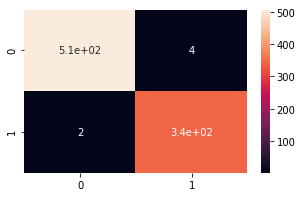

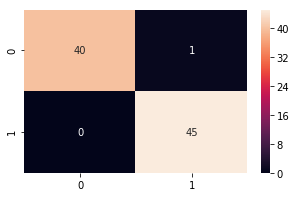

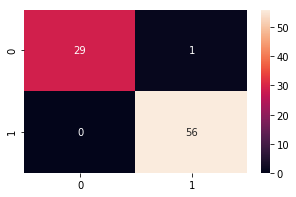

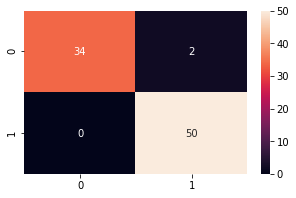

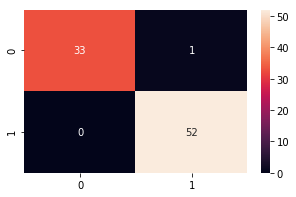

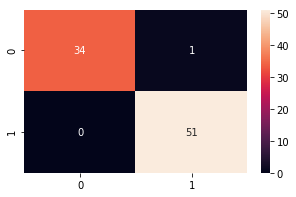

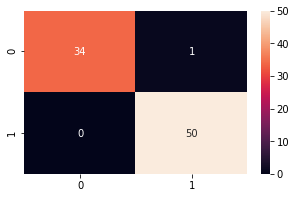

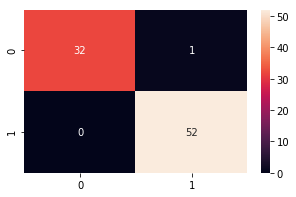

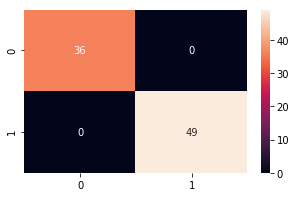

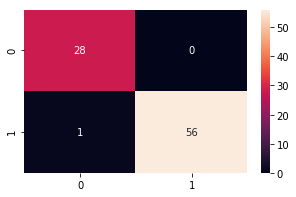

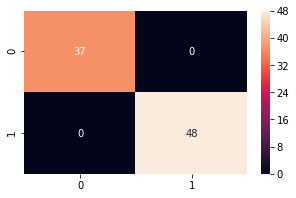

In [0]:
import csv
import numpy as np
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

np.random.seed(5)
inputSize = 165
outputCol = inputSize + 1
import pandas as pd
dataset = pd.read_excel("input.xlsx")
#dataset = np.genfromtxt("./FVs.csv", delimiter=",", dtype=float)
dataset = dataset.values
df = np.array(dataset)
for i in range(len(df)):
  for j in range(len(df[i])):
    if df[i][j] in ['NAN']:
      #print(df[i][j])
      df[i][j] = 0
      
X = df[:,1:inputSize]
Y = df[:,0]
Y = np.array(Y)
print(Y.shape)
#for i in range(len(Y)):
 # if Y[i] not in [0,1]:
    #print(i)
 
Y = np.reshape(Y,[Y.shape[0],1])

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(Y)
print(onehot_encoded.shape)
#print(onehot_encoded)
Y = onehot_encoded
std_scale = StandardScaler().fit(X)
X = std_scale.transform(X)
print('Self-Consistency')
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
clf = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=-1, warm_start=True).fit(X, Y)
pred = np.round(clf.predict(X))

y1 = np.argmax(Y,axis=1)
y2 = np.argmax(pred,axis=1)

tn, fp, fn, tp = confusion_matrix(y1,y2,labels=[0,1]).ravel()
acc = np.round(((tn+tp)/(tn+fp+fn+tp))*100, 2)
print([tn,fp,fn,tp,acc])
print('k-fold')

import matplotlib.pyplot as plt
import seaborn as sn

df_cm = pd.DataFrame([[tn,fp],[fn,tp]], index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)

self_scores = []
self_scores.append([tn,fp,fn,tp,acc])

kfold = KFold(n_splits=10, shuffle=True)
cvscores = []

iterator = 1
cv_score = 0
for train, test in kfold.split(X, Y):
    print('Fold : '+str(iterator))
    clf = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=-1, warm_start=True).fit(X, Y)
    pred = np.round(clf.predict(X[test]))
    tn, fp, fn, tp = confusion_matrix(np.argmax(Y[test],axis=1), np.argmax(pred,axis=1), labels=[1,0]).ravel()
    acc = np.round(((tn+tp)/(tn+fp+fn+tp))*100, 2)
    cvscores.append([tn,fp,fn,tp,acc])
    df_cm = pd.DataFrame([[tn,fp],[fn,tp]], index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cm, annot=True)
    iterator=iterator+1
    print([tn,fp,fn,tp,acc])
    cv_score = cv_score + acc
print('\n\rFinal 10CV Score = ', np.round(cv_score/kfold.n_splits,2),'\n\rResults are Saved in CrossValidationResults.csv\n\r')
with open('./CrossValidationResults.csv', 'w', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=',', quotechar='|')
    resultwriter.writerow(['True Negative', 'False Positive', 'False Negative', 'True Positive', 'Accuracy'])
    resultwriter.writerow(self_scores)
    resultwriter.writerow(['True Negative', 'False Positive', 'False Negative', 'True Positive', 'Accuracy'])
    for i in range(cvscores.__len__()):
        resultwriter.writerow(cvscores[i])
    resultwriter.writerow(['The Final 10CV Score','','','',np.round(cv_score/kfold.n_splits,2)])


In [0]:
from keras.models import Sequential
from keras.layers import Dense,Conv1D
from sklearn.utils import class_weight
import keras

for train, test in kfold.split(X, Y2):
    print('Fold : '+str(iterator))
    model = Sequential()
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=0.001),
                  metrics=['accuracy'])
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(Y,axis=1)),
                                                 np.argmax(Y[train],axis=1))
    
    print(class_weights)
    
    model.fit(X[train], Y[train], epochs=1000, batch_size=1,class_weight=class_weights)
    pred = np.round(clf.predict(X[test]))
    tn, fp, fn, tp = confusion_matrix(np.argmax(Y[test],axis=1), np.argmax(pred,axis=1), labels=[1,0]).ravel()
    acc = np.round(((tn+tp)/(tn+fp+fn+tp))*100, 2)
    cvscores.append([tn,fp,fn,tp,acc])
    df_cm = pd.DataFrame([[tn,fp],[fn,tp]], index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cm, annot=True)
    iterator=iterator+1
    print([tn,fp,fn,tp,acc])
    cv_score = cv_score + acc
print('\n\rFinal 10CV Score = ', np.round(cv_score/kfold.n_splits,2),'\n\rResults are Saved in CrossValidationResults.csv\n\r')
with open('./CrossValidationResults.csv', 'w', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=',', quotechar='|')
    resultwriter.writerow(['True Negative', 'False Positive', 'False Negative', 'True Positive', 'Accuracy'])
    resultwriter.writerow(self_scores)
    resultwriter.writerow(['True Negative', 'False Positive', 'False Negative', 'True Positive', 'Accuracy'])
    for i in range(cvscores.__len__()):
        resultwriter.writerow(cvscores[i])
    resultwriter.writerow(['The Final 10CV Score','','','',np.round(cv_score/kfold.n_splits,2)])


ValueError: ignored

In [0]:
print(X.shape)

(3572, 2)
